### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

### Reading dataset

In [2]:
tweets_train = pd.read_csv('/Users/sonali/Documents/Okstate/Spring\'24/CS5723_Spring\'24/Project/nlp-getting-started/train.csv')
tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
# NOT a disaster tweet
tweets_train[tweets_train["target"] == 0]["text"].values[1]

'I love fruits'

In [4]:
# a disaster tweet
tweets_train[tweets_train["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Text preprocessing

In [5]:
# Removing urls
urls_pattern = r'https?://\S+|www\.\S+'
tweets_train['text'] = tweets_train['text'].str.replace(urls_pattern,'',regex=True)

In [6]:
# Changing text to lower case
tweets_train['text'] = tweets_train['text'].apply(lambda x : " ".join(x.lower() for x in x.split()))

In [7]:
# Removing numbers
numpattern = '\\b[0-9]+\\b'
tweets_train['text'] = tweets_train['text'].str.replace(numpattern,'',regex=True)

In [8]:
# Removing punctuation
puncpattern = '[^\w\s]'
tweets_train['text'] = tweets_train['text'].str.replace(puncpattern,'',regex=True)

In [9]:
# Remove spaces from the start or end of text 
tweets_train['text'] = tweets_train['text'].apply(lambda x : x.strip())

In [10]:
# Removing stop words
stop = stopwords.words('english')
tweets_train['text'] = tweets_train['text'].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

In [11]:
# Lemmatization
lemma = WordNetLemmatizer()
tweets_train['text'] = tweets_train['text'].apply(lambda x : " ".join(lemma.lemmatize(x) for x in x.split()))

### Data visualization

In [12]:
# Setting plot size
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 4
plot_size[1] = 3
plt.rcParams["figure.figsize"] = plot_size

Text(0.5, 1.0, 'Tweets by Target')

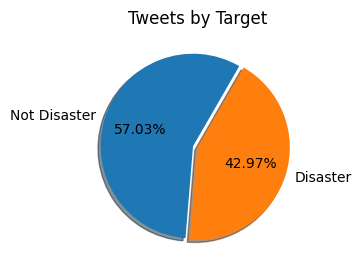

In [13]:
# Pie chart for Tweets distribution by 'Target'
plt.pie(tweets_train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
plt.title('Tweets by Target')

#### ~43% of texts are classified into “Disaster” category compared to ~57% "Non-disaster" tweets. There is no major class imbalance. 

In [14]:
# Creating dataframe with tokens
vect = CountVectorizer()
dis_tokens_df = pd.DataFrame(vect.fit_transform(tweets_train[tweets_train['target'] == 1]['text']).toarray(), columns = vect.get_feature_names_out())
nondis_tokens_df = pd.DataFrame(vect.fit_transform(tweets_train[tweets_train['target'] == 0]['text']).toarray(), columns = vect.get_feature_names_out())

Text(0.5, 1.0, 'Top 30 Words for Non-Disaster Tweets')

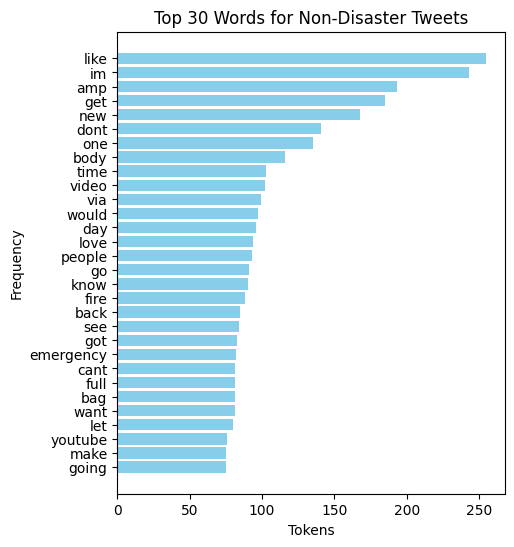

In [15]:
# Barchart for Top 30 Words for Non-Disaster Tweets
tokens = nondis_tokens_df.sum()
plt.figure(figsize=(5, 6))
plt.barh(tokens.sort_values(ascending = False)[:30].index,
        tokens.sort_values(ascending = False)[:30].values,
        color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.gca().invert_yaxis()
plt.title('Top 30 Words for Non-Disaster Tweets')

Text(0.5, 1.0, 'Top 30 Words for Disaster Tweets')

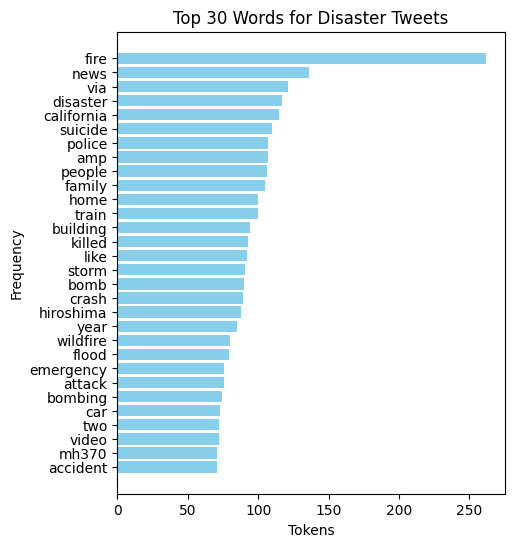

In [16]:
# Barchart for Top 30 Words for Disaster Tweets
tokens = dis_tokens_df.sum()
plt.figure(figsize=(5, 6))
plt.barh(tokens.sort_values(ascending = False)[:30].index,
        tokens.sort_values(ascending = False)[:30].values,
        color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.gca().invert_yaxis()
plt.title('Top 30 Words for Disaster Tweets')

In [17]:
# Removing other irrelevant terms ('via' and 'amp' are the top words for both disaster and nondisaster tweets)
# These words are not helpful for text classification
list_words = ['via','amp']
tweets_train['text'] = tweets_train['text'].apply(lambda x : " ".join(x for x in x.split() if x not in list_words))

In [18]:
# Top 5 rows for training dataset after pre-processing
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [19]:
# Saving pre-processed dataframes
tweets_train.to_csv('train_processed.csv', index=False)

In [20]:
# Extracting Top 30 bigrams for disaster tweets
vect = CountVectorizer(ngram_range=(2, 2))
dis_tokens_matrix = vect.fit_transform(tweets_train[tweets_train['target'] == 1]['text'])
dis_tokens_df = pd.DataFrame(dis_tokens_matrix.toarray(), columns=vect.get_feature_names_out())
dis_bi_grams = dis_tokens_df.columns.tolist()
bigram_counts = dis_tokens_df.sum()
top_30_bigrams = bigram_counts.nlargest(30)
top_30_bigram_names = top_30_bigrams.index.tolist()

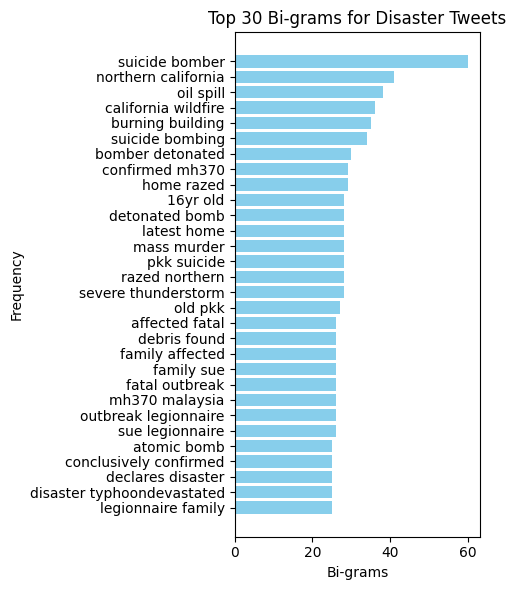

In [21]:
# Barchart for Top 30 bigrams for Disaster Tweets
top_30_bigram_counts = [bigram_counts[bigram] for bigram in top_30_bigram_names]
plt.figure(figsize=(5, 6))
plt.barh(top_30_bigram_names, top_30_bigram_counts, color='skyblue')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.title('Top 30 Bi-grams for Disaster Tweets')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
# Extracting Top 30 bigrams for non-disaster tweets
nondis_tokens_matrix = vect.fit_transform(tweets_train[tweets_train['target'] == 0]['text'])
nondis_tokens_df = pd.DataFrame(nondis_tokens_matrix.toarray(), columns=vect.get_feature_names_out())
nondis_bi_grams = nondis_tokens_df.columns.tolist()
bigram_counts = nondis_tokens_df.sum()
top_30_bigrams = bigram_counts.nlargest(30)
top_30_bigram_names = top_30_bigrams.index.tolist()

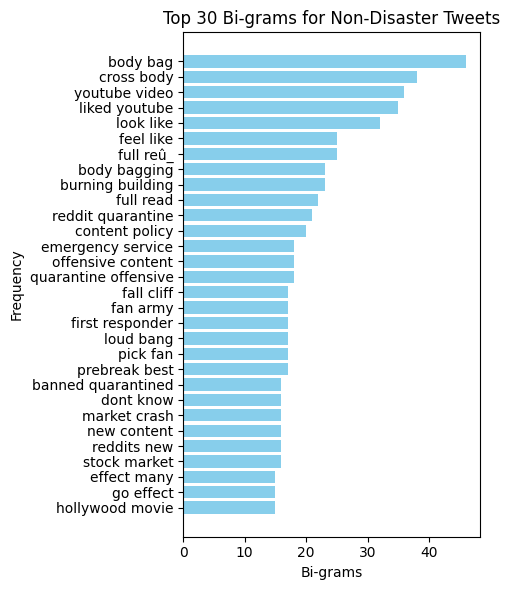

In [23]:
# Barchart for Top 30 bigrams for non-disaster Tweets
top_30_bigram_counts = [bigram_counts[bigram] for bigram in top_30_bigram_names]
plt.figure(figsize=(5, 6))
plt.barh(top_30_bigram_names, top_30_bigram_counts, color='skyblue')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.title('Top 30 Bi-grams for Non-Disaster Tweets')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Top bigrams for disaster tweets include “suicide bomber”, “northern california” and “oil spill” which are clearly describing disasters whereas for non-disaster tweets, most of the top 30 bigrams are generic like “cross body” and “youtube video”, however some bigrams like “body bag” and “burning building” are confusing and need further research.

In [24]:
# Adding new column "word_count" showing number of words in each tweet text
tweets_train['word_count'] = tweets_train['text'].map(lambda x: len(x.split()))

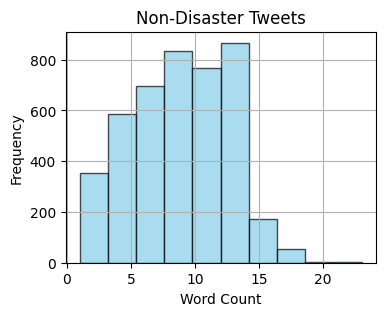

In [25]:
# Distribution of word counts in non-disaster tweets
plt.hist(tweets_train[tweets_train['target'] == 0]['word_count'], color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Non-Disaster Tweets')
plt.show()

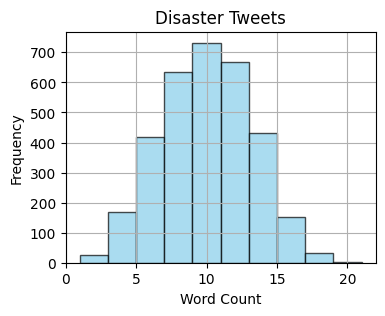

In [26]:
# Distribution of word counts in disaster tweets
plt.hist(tweets_train[tweets_train['target'] == 1]['word_count'], color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Disaster Tweets')
plt.show()

#### Non-disaster tweets have slightly more words than disaster tweets

### Topics extraction

In [27]:
# Converting a text documents to a matrix of token counts
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(tweets_train['text'].values.astype('U'))
doc_term_matrix.shape

(7613, 1250)

In [28]:
# Using LDA, a topic modeling technique, to analyze the texts
LDA = LatentDirichletAllocation(n_components=5, random_state=35)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=35)

In [29]:
# Extracting 5 key topics
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['school', 'good', 'wildfire', 'man', 'dead', 'attack', 'burning', 'california', 'police', 'building']


Top 10 words for topic #1:
['news', 'train', 'bombing', 'collapse', 'oil', 'life', 'hostage', 'new', 'suicide', 'emergency']


Top 10 words for topic #2:
['thunderstorm', 'wreck', 'weapon', 'watch', 'like', 'disaster', 'youtube', 'nuclear', 'storm', 'video']


Top 10 words for topic #3:
['train', 'car', 'crash', 'need', 'year', 'got', 'like', 'know', 'dont', 'im']


Top 10 words for topic #4:
['woman', 'bomb', 'mass', 'disaster', 'bag', 'family', 'new', 'like', 'love', 'body']




#### The key words suggest that the key topics are related to California wildfire burning, oil spill, thunderstorm disaster, car or train crash and bomb attack 

In [30]:
# Probability distribution of topics for each document in the dataset
topic_values = LDA.transform(doc_term_matrix)
topic_values

array([[0.06666996, 0.066667  , 0.06678478, 0.06698599, 0.73289227],
       [0.04055458, 0.23999742, 0.04040893, 0.63889494, 0.04014413],
       [0.4249908 , 0.48901779, 0.02857177, 0.02875028, 0.02866937],
       ...,
       [0.06666732, 0.06666739, 0.73333054, 0.06666722, 0.06666753],
       [0.27438324, 0.02870217, 0.32898725, 0.33891772, 0.02900961],
       [0.91080012, 0.02236487, 0.0222847 , 0.02226263, 0.02228767]])

In [31]:
# Adding new column "topic_lda" showing topic for each text
tweets_train['topic_lda'] = topic_values.argmax(axis=1)

Text(0.5, 1.0, 'Distribution of the Texts by Topic')

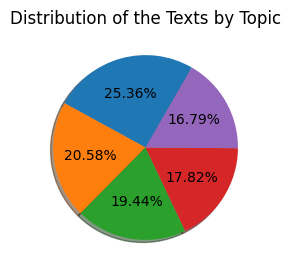

In [32]:
# Pie chart showing distribution of Texts by Topic
plt.pie(tweets_train['topic_lda'].value_counts(),
            autopct='%1.2f%%',
            shadow=True,
            startangle=60)
plt.title('Distribution of the Texts by Topic')

### Word clouds

In [33]:
# Function to plot wordclouds
def plot_wordcloud(text_data, title, title_size=20):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(text_data))
    
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(title, fontsize=title_size)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show()

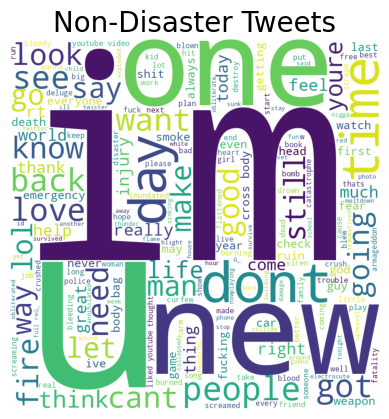

In [34]:
# Word cloud for Non-Disaster Tweets
plot_wordcloud(tweets_train[tweets_train['target'] == 0]['text'],
               'Non-Disaster Tweets')

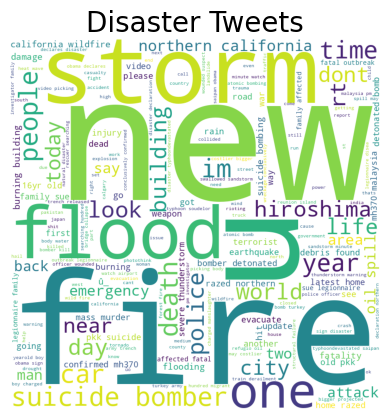

In [35]:
# Word cloud for Disaster Tweets
plot_wordcloud(tweets_train[tweets_train['target'] == 1]['text'],
               'Disaster Tweets')